In [30]:
# 0.1 Import numpy and pandas
import numpy as np
import pandas as pd

In [31]:
# 0.2 Read data
data = pd.read_excel('gorilla_test_data.xlsx', sheet_name=None)
uk_meter_data, uk_consump_data, rate_table = data.values()

In [32]:
# 0.3 Get series with rates in pounds (assumption AQ bands same for different meters)
rate_series = rate_table.pivot(index=['date', 'exit_zone', 'aq_min_kwh'], columns=[], values='rate_p_per_kwh')
rate_series *= 0.01

In [33]:
# 0.4 Function computing transportation cost of meters
def get_transport_cost(meter_list, consump_data):

    # Resample consumption data according to 6-month rate periods (assumption 6-month rate period)
    origin_data = pd.DataFrame({'meter_id': meter_list.index, 'date': rate_series.index[0][0], 'kwh': 0.0})
    consump_data = pd.concat([origin_data, consump_data])

    group_kwargs = {'closed': 'left', 'label': 'left', 'on': 'date'}
    cost_table = consump_data.groupby('meter_id').resample('6MS', **group_kwargs)[['kwh']].sum()
    cost_table = cost_table.reset_index()

    # Get rates per meter (assumption AQ bands sorted)
    dates = cost_table['date']
    exit_zones = meter_list['exit_zone'][cost_table['meter_id']]

    aq_min_vals = rate_series.reset_index()['aq_min_kwh'].unique()
    aq_band_ids = (meter_list['aq_kwh'].to_numpy()[:, None] - aq_min_vals[None, :] >= 0).sum(axis=1) - 1
    aq_min_vals = aq_min_vals[aq_band_ids]

    meter_list['aq_min_vals'] = aq_min_vals
    aq_min_vals = meter_list['aq_min_vals'][cost_table['meter_id']]

    rates = rate_series.loc[(dates, exit_zones, aq_min_vals)]
    rates = rates.reset_index(name='rate')['rate']

    # Add 6-month costs to cost table
    cost_table['cost'] = rates * cost_table['kwh']

    # Aggregate 6-month consumption and costs
    cost_table = cost_table.groupby('meter_id')[['kwh', 'cost']].sum()
    cost_table = cost_table.round(decimals=2)
    
    return cost_table

In [34]:
# 1. Transportation distribution charge for four meters in UK
uk_meter_list = uk_meter_data.set_index('meter_id')
cost_table = get_transport_cost(uk_meter_list, uk_consump_data)
print(cost_table)

               kwh     cost
meter_id                   
14676236   28978.0    66.23
34509937   78324.0   182.16
50264822  265667.0   691.00
88357331  484399.0  1425.40


In [35]:
# 2. Function generating random meters
def generate_meter_list(num_meters):
    
    # Generate exit zones
    exit_zones = rate_table['exit_zone'].unique()
    exit_zones = exit_zones[np.random.randint(len(exit_zones), size=[num_meters])]

    # Generate AQs
    aqs = np.random.randint(int(1e6), size=[num_meters])

    # Get date frame with random meters
    meters_list = pd.DataFrame({'exit_zone': exit_zones, 'aq_kwh': aqs})
    meters_list.index.name = 'meter_id'

    return meters_list

random_meter_list = generate_meter_list(num_meters=4)
print(random_meter_list)

         exit_zone  aq_kwh
meter_id                  
0              SC2   14395
1              NE1  819113
2              NT3  397695
3              SE1  631735


In [36]:
# 3. Function generating random consumption data
def generate_consump_data(meter_list, num_days, start_day='04/01/2020'):

    # Get number of meters and meter ids
    num_meters = len(meter_list)
    meter_ids = meter_list.index.to_numpy().repeat(num_days)

    # Generate dates and consumptions
    dates = np.tile(pd.date_range(start=start_day, periods=num_days).to_numpy(), num_meters)
    consumps = 1e3 * np.random.random(size=[num_meters * num_days])

    # Get data frame with random consumption data
    consump_data = pd.DataFrame({'meter_id': meter_ids, 'date': dates, 'kwh': consumps})

    return consump_data

random_consump_data = generate_consump_data(random_meter_list, num_days=4)
print(random_consump_data)

    meter_id       date         kwh
0          0 2020-04-01  549.099870
1          0 2020-04-02  488.690021
2          0 2020-04-03  219.179509
3          0 2020-04-04  226.764078
4          1 2020-04-01  457.489670
5          1 2020-04-02  630.823084
6          1 2020-04-03  678.507731
7          1 2020-04-04  914.232274
8          2 2020-04-01  192.177549
9          2 2020-04-02   83.229375
10         2 2020-04-03  540.803511
11         2 2020-04-04  901.490483
12         3 2020-04-01  625.411976
13         3 2020-04-02  738.345446
14         3 2020-04-03   61.894559
15         3 2020-04-04  443.120083


In [37]:
# 4.1. Get random cost table
random_cost_table = get_transport_cost(random_meter_list, random_consump_data)
print(random_cost_table)

              kwh  cost
meter_id               
0         1483.73  3.03
1         2681.05  6.89
2         1717.70  4.72
3         1868.77  5.28


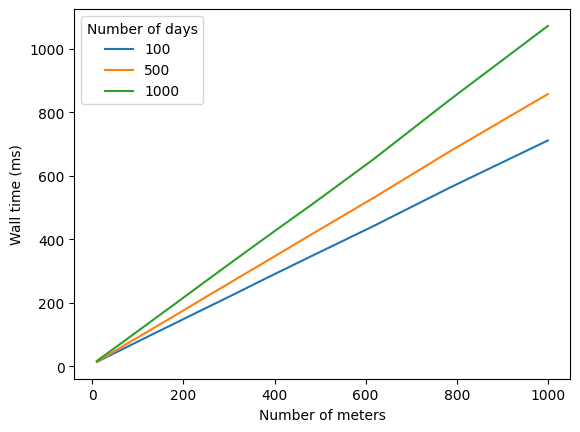

In [38]:
# 4.2 Benchmark transportation cost function w.r.t. number of meters
import matplotlib.pyplot as plt
from timeit import default_timer as timer

num_days_list = [100, 500, 1000]
num_meters_list = list(np.logspace(1, 3, num=20).astype(int))
num_repeats = 3

for num_days in num_days_list:
    times = []

    for num_meters in num_meters_list:
        meter_list = generate_meter_list(num_meters)
        consump_data = generate_consump_data(meter_list, num_days)
        local_times = []

        for _ in range(num_repeats):
            tic = timer()
            get_transport_cost(meter_list, consump_data)
            toc = timer()

            local_time = 1000 * (toc - tic)
            local_times.append(local_time)

        time = np.median(np.array(local_times))
        times.append(time)

    plt.plot(num_meters_list, times)

plt.xlabel('Number of meters')
plt.ylabel('Wall time (ms)')
plt.legend([100, 500, 1000], title='Number of days')

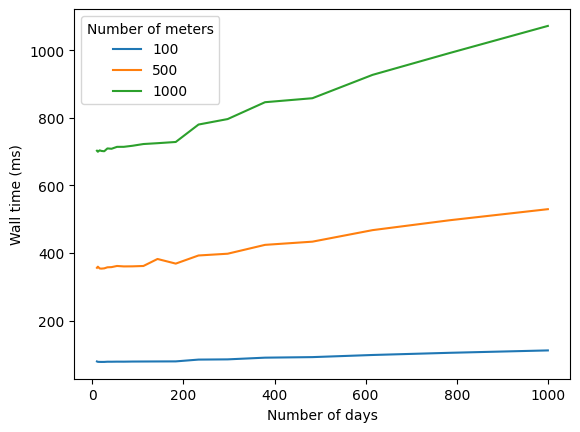

In [39]:
# 4.3 Benchmark transportation cost function w.r.t. number of days
num_meters_list = [100, 500, 1000]
num_days_list = list(np.logspace(1, 3, num=20).astype(int))
num_repeats = 3

for num_meters in num_meters_list:
    times = []

    for num_days in num_days_list:
        meter_list = generate_meter_list(num_meters)
        consump_data = generate_consump_data(meter_list, num_days)
        local_times = []

        for _ in range(num_repeats):
            tic = timer()
            get_transport_cost(meter_list, consump_data)
            toc = timer()

            local_time = 1000 * (toc - tic)
            local_times.append(local_time)

        time = np.median(np.array(local_times))
        times.append(time)

    plt.plot(num_days_list, times)

plt.xlabel('Number of days')
plt.ylabel('Wall time (ms)')
plt.legend([100, 500, 1000], title='Number of meters')

In [29]:
# 5. Discussion

# 1. The computation time increases linearly with the number of meters.
# 2. The computation time also increases linearly with the number of days,
#    but its impact is weaker than the number of meters.